In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Gwen implementation 

In [2]:
def prob3():
    '''
    Solve the free time horizon BVP.
    Plot the solution and return the correct end time
    '''
    
    Pu = 9
    Pl = 7
    sigma = .1**2
    sy = 1

    tf = 3
    t0 = 0 


    #define ode 
    def ode(t,y):
        ''' define the ode system '''
        K = 1
        #x, y, x', y', p1, p2, p3, p4 

        #return np.array([(y[0] + .1*y[2]), (y[1] + .1*y[3]),y[3],-9.8 + y[4] + y[7], y[0]*0, y[0]*0, y[0]*0, -y[5]])
        #return np.array([y[2], y[3], 0*y[0], -9.8 + y[7], 0*y[0], 0*y[0], -y[4], -y[5]])
        return np.array([y[1], -9.8 + y[3], 0*y[0], y[2]])
    
    def bc(ya,yb):
        ''' define the boundary conditions '''
        '''return np.array([ya[0] - sx, ya[1] - sy, ya[2] - C, ya[3], 
                         yb[0] - 1,yb[2] - C, yb[5] + 1/sigma*np.exp(-((yb[1] - (Pu + Pl)/2)**2)/sigma)*2*(yb[1] - (Pu + Pl)/2), yb[7] - 0])'''
        return np.array([ya[0] - sy, ya[1] - 0, yb[2] + 1/sigma*np.exp(-((yb[0] - (Pu + Pl)/2)**2)/sigma)*2*(yb[0] - (Pu + Pl)/2), yb[3] - 0])
    
    # give the time domain
    t_steps = 100 
    t = np.linspace(0,3,t_steps)

    # give an initial guess
    y_guess = np.linspace(sy, (Pu+Pl)/2, t_steps)
    yp_guess = np.ones(t_steps)*(((Pu+Pl)/2 - sy) / (tf - t0))
    p0_guess = np.zeros(t_steps)
    p1_guess = np.ones(t_steps)
    y0 = np.vstack((y_guess, yp_guess, p0_guess, p1_guess))

    # solve the system
    sol = solve_bvp(ode, bc, t, y0)

    print(sol)



    #plot
    plt.plot(sol.x, sol.y[0])
    plt.xlabel("t")
    plt.ylabel("y(t)")
    plt.title("Problem 3")
    plt.show()

    return   

       message: The algorithm converged to the desired accuracy.
       success: True
        status: 0
             x: [ 0.000e+00  3.030e-02 ...  2.970e+00  3.000e+00]
           sol: <scipy.interpolate._interpolate.PPoly object at 0x14614f420>
             p: None
             y: [[ 1.000e+00  1.003e+00 ...  8.143e+00  8.031e+00]
                 [-5.354e-21  2.169e-01 ... -3.540e+00 -3.834e+00]
                 [-5.681e+00 -5.681e+00 ... -5.681e+00 -5.681e+00]
                 [ 1.704e+01  1.687e+01 ...  1.722e-01  0.000e+00]]
            yp: [[-5.354e-21  2.169e-01 ... -3.540e+00 -3.834e+00]
                 [ 7.244e+00  7.072e+00 ... -9.628e+00 -9.800e+00]
                 [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
                 [-5.681e+00 -5.681e+00 ... -5.681e+00 -5.681e+00]]
 rms_residuals: [ 1.653e-14  2.875e-15 ...  2.767e-15  8.793e-15]
         niter: 1


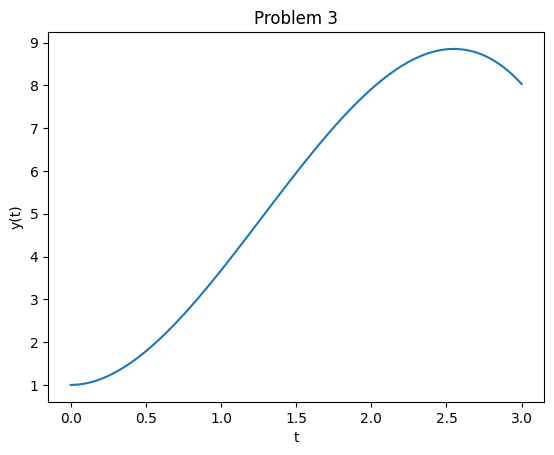

In [3]:
prob3()

## Obstacle avoidance 

In [5]:
def obstacle(x,y,W1=1,r=(1,1),c=(0,0)):
    '''
    Define an area that will represent an obstacle
    
    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    ellipse = ((x - c[0])**2/r[0] + (y - c[1])**2/r[1])**20 + 1

    return W1 / ellipse

def obstacle_dx(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    x derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40* W1 * (x-c[0])*(circle)**19
    denom = r[0]*((circle)**20 + 1)**2

    return numer / denom

def obstacle_dy(x,y,W1=1,r=(1,1,),c=(0,0)):
    '''
    y derivative of the obstacle

    Parameters:
        x (float): x position in space
        y (float): y position in space
        W1 (float): weight of cost
        r (tuple): radius in x and y direction
        c (tuple): center of the ellipse
    '''

    circle = (x - c[0])**2/r[0] + (y - c[1])**2/r[1]
    numer = -40 * W1 * (y-c[1])*(circle)**19
    denom = r[1]*((circle)**20 + 1)**2

    return numer / denom

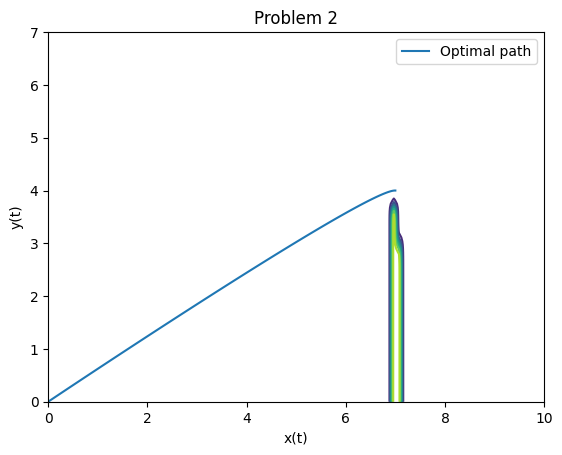

In [66]:
def prob2():
    '''
    Find the optimal path for the fixed time horizon problem
    '''
    #define Ws 
    W1 = 20
    W2 = .1

    #define X and Y 
    X = np.linspace(0,7,100)
    Y = np.linspace(0,2,100)
    
    #define y0 
    y0 = 1*np.ones((8, X.size))


    #define functions
    def fun(t, z):
        return np.vstack((z[2],z[3], 1/(2*W2)*z[6], 1/(2*W2)*z[7],obstacle_dx(z[0],z[1],W1=W1,r=(.01,8,),c=(7,1)),obstacle_dy(z[0],z[1],W1=W1,r=(.01,8,),c=(7,1)), -z[4], -z[5]))
    
    def bc(ya, yb):
        return np.array([ya[0], ya[1], ya[2], ya[3], yb[0] - 7, yb[1] - 4, yb[2], yb[3]])
    
    #solve and get x and y 
    res_a = solve_bvp(fun, bc, X, y0, max_nodes = 30000)

    x1 = res_a.y[0]
    y2 = res_a.y[1]

    #find obstacle 
    X = np.linspace(0,10,100)
    Y = np.linspace(0,7,100)
    x_,y_ = np.meshgrid(X,Y)
    obs = obstacle(x_,y_,W1=W1,r=(.01,8),c=(7,1))

    #plot
    plt.contour(x_, y_, obs)
    plt.plot(x1,y2, label = "Optimal path")
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.ylim(0,7)
    plt.title("Problem 2")
    plt.legend()
    plt.show()

prob2()

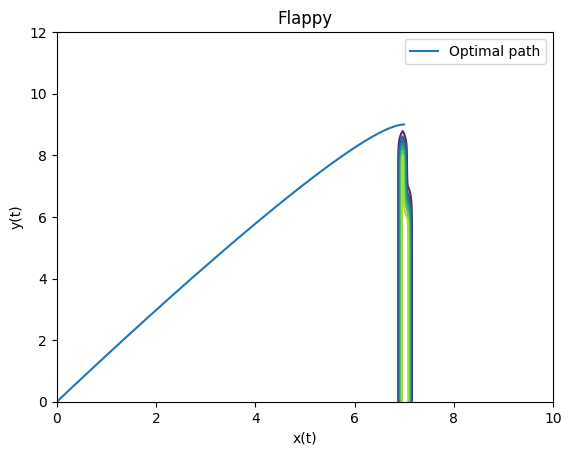

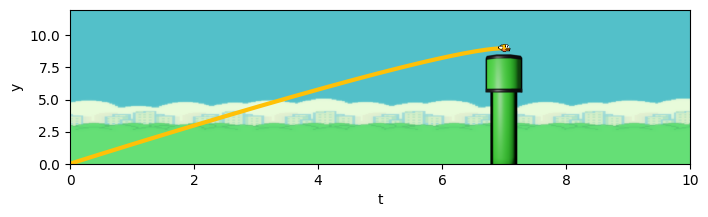

In [123]:
def prob2(W1 = 20, W2 = .1, rx = .01, ry = 60, center = (7,1), start_location = [0,0], end_location = [7,9]):


    #define X and Y 
    X = np.linspace(start_location[0],end_location[0] + 3,100)
    Y = np.linspace(start_location[1],end_location[1],100)

    #define y0 
    y0 = 1*np.zeros((8, X.size))


    #define functions
    def fun(t, z):
        return np.vstack((z[2],z[3], 1/(2*W2)*z[6], 1/(2*W2)*z[7],obstacle_dx(z[0],z[1],W1=W1,r=(rx,ry,),c=center),obstacle_dy(z[0],z[1],W1=W1,r=(rx,ry,),c=center), -z[4], -z[5]))
    
    def bc(ya, yb):
        return np.array([ya[0]- start_location[0], ya[1] - start_location[1], ya[2], ya[3], yb[0] - end_location[0], yb[1] - end_location[1], yb[2], yb[3]])
    
    #solve and get x and y 
    res_a = solve_bvp(fun, bc, X, y0)

    x1 = res_a.y[0]
    y2 = res_a.y[1]

    #find obstacle 
    X = np.linspace(start_location[0],end_location[0] + 3,100)
    Y = np.linspace(0,end_location[1],100)
    x_,y_ = np.meshgrid(X,Y)
    obs = obstacle(x_,y_,W1=W1,r=(rx,ry),c=center)

    #plot
    plt.contour(x_, y_, obs)
    plt.plot(x1,y2, label = "Optimal path")
    plt.xlabel("x(t)")
    plt.ylabel("y(t)")
    plt.xlim(start_location[0], end_location[0] + 3)
    plt.ylim(0,end_location[1] + 3)
    plt.title("Flappy")
    plt.legend()
    plt.show()

    # plot the x(t)
    plt.gcf().set_size_inches(8,2)

    plt.plot(x1, y2, linewidth=3, color="#ffc107")
    plt.xlabel("t")
    plt.ylabel("y")

    xlims = (start_location[0], end_location[0] + 3)
    ylims = (0,end_location[1] + 3)
    # plot the background
    background = mpimg.imread('images/flappy_background.png')
    plt.imshow(background, extent=[xlims[0], xlims[1], ylims[0], ylims[1]], aspect='auto', alpha=1)


    xmin, xmax = end_location[0] - .3, end_location[0] + .3
    ymin, ymax = 0, end_location[1] - .5
    img = mpimg.imread('images/pipe_cropped_lower.png')
    plt.imshow(img, extent=[xmin, xmax, ymin, ymax], aspect='auto')

    # plot the bird
    xmin, xmax = end_location[0] -.1 , end_location[0] + .1
    ymin, ymax = end_location[1] - .3, end_location[1] + .3
    bird = mpimg.imread('images/bird_cropped.png')
    plt.imshow(bird, extent=[xmin, xmax, ymin, ymax], aspect='auto', zorder=2)

    plt.xlim(start_location[0], end_location[0] + 3)
    plt.ylim(0,end_location[1] + 3)
    plt.show()

prob2()

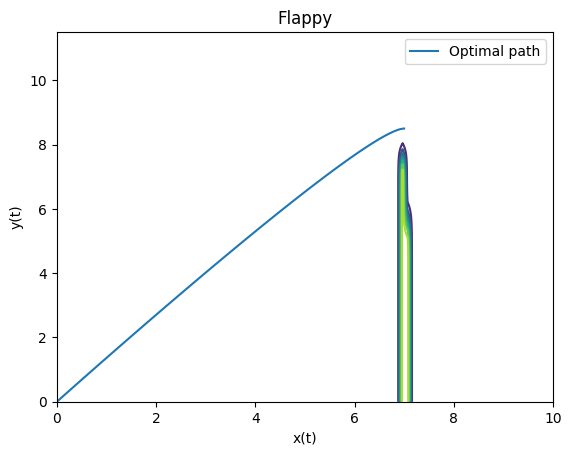

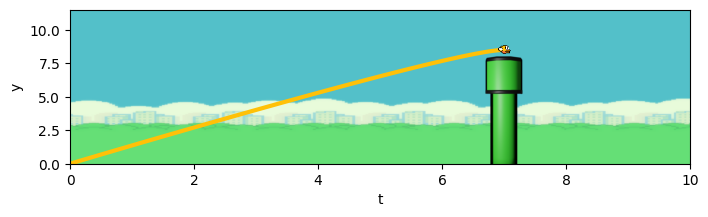

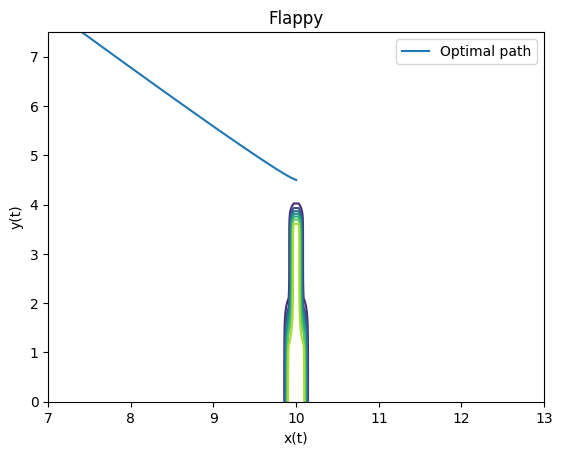

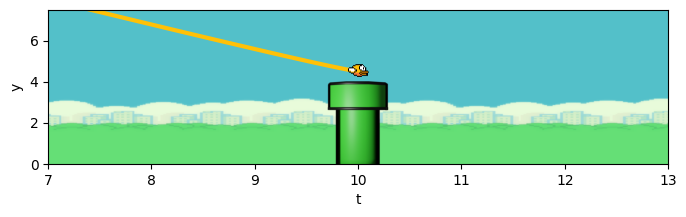

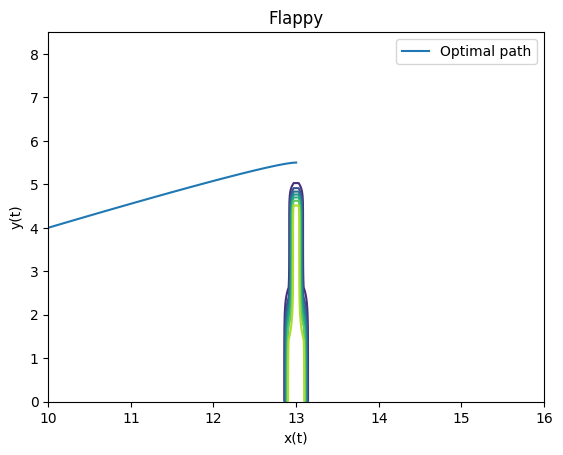

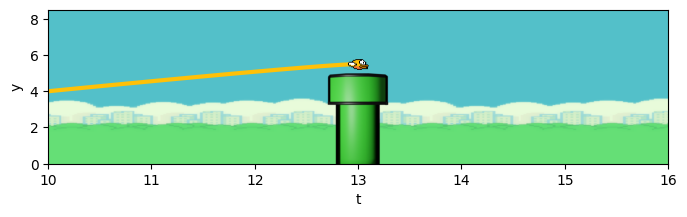

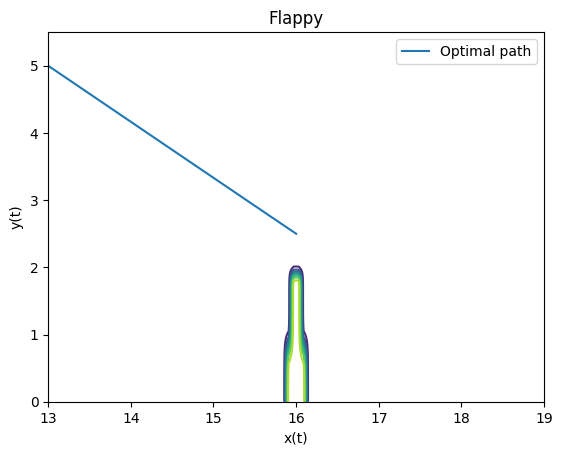

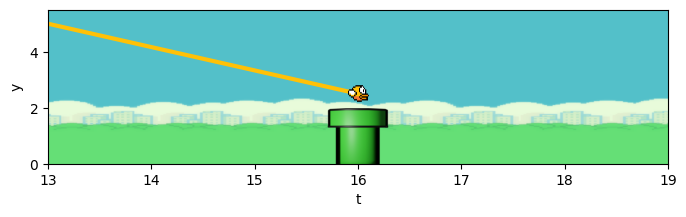

In [124]:
xs = [7, 10, 13, 16]
ys = [8, 4, 5, 2]
#ry = [8, 3, 6, 5]

start_loc_x = [0, 7, 10, 13]
start_loc_y = [0, 8, 4, 5]

for i in range(4):

    prob2(W1 = 20, W2 = .1, rx = .01, ry = ys[i]**2, center = (xs[i],0), start_location = [start_loc_x[i],start_loc_y[i]], end_location = [xs[i],ys[i]+.5])